In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

# 0. Data

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

DATA_PATH = '../data/train_data.csv'
df = pd.read_csv(DATA_PATH, dtype=dtype, parse_dates=['Timestamp'])
df = df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)
df

CPU times: user 3.79 s, sys: 352 ms, total: 4.14 s
Wall time: 4.14 s


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [3]:
df.dtypes

userID                       int16
assessmentItemID            object
testId                      object
answerCode                    int8
Timestamp           datetime64[ns]
KnowledgeTag                 int16
dtype: object

In [4]:
df.isna().sum()

userID              0
assessmentItemID    0
testId              0
answerCode          0
Timestamp           0
KnowledgeTag        0
dtype: int64

In [5]:
df[df['assessmentItemID'].str[1:7] != df['testId'].str[1:4] + df['testId'].str[7:]]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag


## Timestamp 처리

### 1) 문제 푸는 데 걸린 시간
* groupby('userID')로만 해줘도 될까??
* 다음 문제지를 바로 푸나??
* userID, testId로 묶을 경우
    * 첫번째 문제 푸는 시간이 0으로 됨
    * 마지막 문제 푸는 시간을 알 수 없음

In [6]:
# 유저로만 구분했을 때 문제 푸는데 걸린 시간
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['solved_time'] = diff
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solved_time
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0


In [7]:
df_first = df.drop_duplicates(subset=['userID', 'testId'], keep='first')
print('전체 푸는데 걸린 시간 평균', df['solved_time'].mean())
print('testset 마지막 푸는데 걸린 시간 평균', df_first['solved_time'].mean())
df_first.head()

전체 푸는데 걸린 시간 평균 52685.91680792169
testset 마지막 푸는데 걸린 시간 평균 322625.2935064793


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solved_time
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,192856.0
13,0,A060005001,A060000005,1,2020-03-31 05:02:52,7227,428921.0
20,0,A060007001,A060000007,1,2020-04-02 04:53:37,7229,172069.0
27,0,A080002001,A080000002,1,2020-04-06 00:35:01,4605,329453.0


In [8]:
# 유저, test로 구분했을 때 문제 푸는데 걸린 시간
diff_test = df.loc[:, ['userID', 'testId', 'Timestamp']].groupby(['userID', 'testId']).diff().fillna(pd.Timedelta(seconds=0))
diff_test = diff_test.fillna(pd.Timedelta(seconds=0))
diff_test = diff_test['Timestamp'].apply(lambda x: x.total_seconds())

df['solved_time_test'] = diff_test
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solved_time,solved_time_test
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0,3.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0,8.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0,7.0


In [9]:
# 문제 번호 001로 끝나는게 값 다름 > 첫번쨰 문제 처리 방식이 다르기 때문
print('유저로만 묶었을 때 푸는데 걸린 시간 평균', df['solved_time'].mean())
print('유저, 문제지로 묶었을 때 푸는데 걸린 시간 평균', df['solved_time_test'].mean())
df[df['solved_time'] != df['solved_time_test']].head()

유저로만 묶었을 때 푸는데 걸린 시간 평균 52685.91680792169
유저, 문제지로 묶었을 때 푸는데 걸린 시간 평균 14486.002520089685


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solved_time,solved_time_test
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,192856.0,0.0
13,0,A060005001,A060000005,1,2020-03-31 05:02:52,7227,428921.0,0.0
20,0,A060007001,A060000007,1,2020-04-02 04:53:37,7229,172069.0,0.0
27,0,A080002001,A080000002,1,2020-04-06 00:35:01,4605,329453.0,0.0
33,0,A060009001,A060000009,1,2020-04-07 01:42:13,7230,90248.0,0.0


----
# 1. EDA

## 1-1. userID

In [10]:
user_df = df.groupby('userID')['answerCode'].agg({'mean', 'count'})
user_df = user_df.sort_values(by='count', ascending=False)

/tmp/ipykernel_19447/3485450624.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


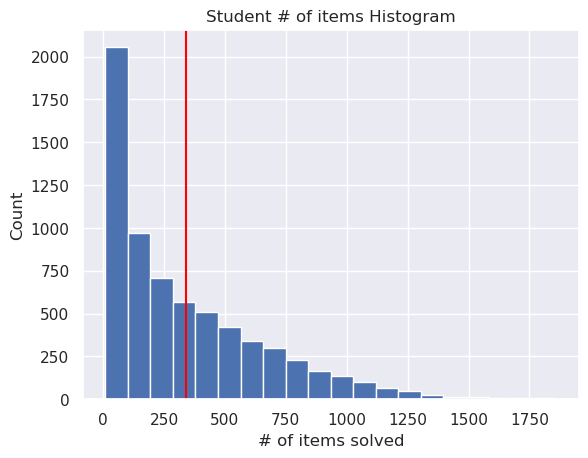

In [11]:
# 사용자 문항 개수 도수분포표
fig, ax = plt.subplots()

user_df['count'].hist(bins=20, ax=ax)

ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(user_df['count'].mean(), color='red')
ax.grid(b=True)

/tmp/ipykernel_19447/2620130816.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


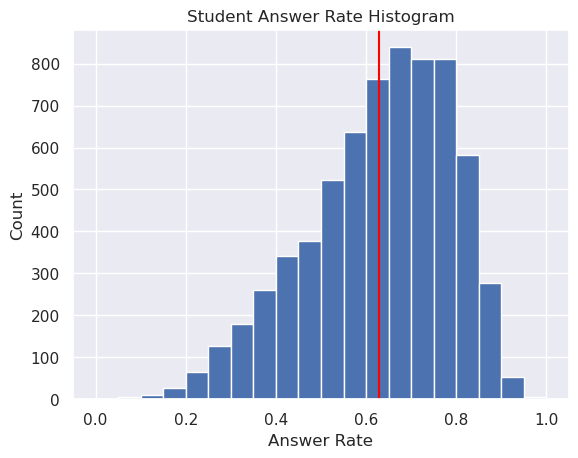

In [12]:
# 사용자 정답률 도수분포표
fig, ax = plt.subplots()

user_df['mean'].hist(bins=20)

ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(user_df['mean'].mean(), color='red')
ax.grid(b=True)

/tmp/ipykernel_19447/2759740271.py:12: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


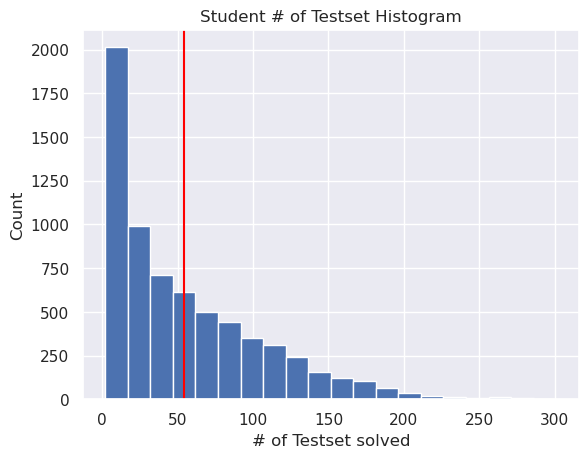

In [13]:
user_test_df = df.groupby('userID')['testId'].agg({'nunique'})

# 사용자 문항 개수 도수분포표
fig, ax = plt.subplots()

user_test_df['nunique'].hist(bins=20, ax=ax)

ax.set_title('Student # of Testset Histogram')
ax.set_xlabel('# of Testset solved')
ax.set_ylabel('Count')
ax.axvline(user_test_df['nunique'].mean(), color='red')
ax.grid(b=True)

### 1) 문제를 많이 푼 유저일 수록 정답률이 높은가?

Text(0.5, 1.0, '# of Questions - Answer Rate')

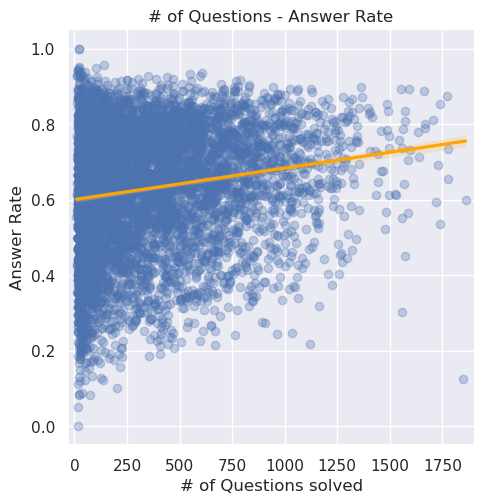

In [14]:

g = sns.lmplot(
	data = user_df,
	x='count',
	y='mean',
	scatter_kws={'alpha':0.3},
	line_kws={"color": "orange"}
)

g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

<br><br>
## 1-2. assessmentItemID

In [15]:
item_df = df.groupby('assessmentItemID')['answerCode'].agg({'mean', 'count'})
item_df = item_df.sort_values(by='count', ascending=False)

In [16]:
# 각 문제는 하나의 테스트에만 할당되어 있음
test = df.groupby('assessmentItemID')['testId'].agg({'count', 'nunique'})
test['nunique'].value_counts()

1    9454
Name: nunique, dtype: int64

#### ⁉️ 왜 문제당 개수가 특정 값으로만 존재할까???
* 시험지 별 푼 학생 수 == 문제지 별 푼 학생 수 라서
* 454, 453, 452와 같이 비슷한 숫자로 수렴하는 이유는 같은 문제지를 받아도 안 푼 학생들이 있기 때문에
* **문제지 내에서 아예 안풀었다는 건 제일 어렵다는 뜻??**

In [17]:
item_df['count'].unique()

array([454, 453, 452, 451, 450, 447, 407, 404, 368, 367, 366, 365, 364,
       363, 362, 361, 360, 359, 358, 327, 324, 323, 322, 321, 320, 319,
       318, 317, 316, 315, 314, 313, 312, 311, 310, 309, 308, 307, 306,
       304, 289, 288, 287, 286, 285, 284, 283, 282, 281, 280, 279, 278,
       277, 276, 275, 274, 273, 272, 271, 270, 269, 268, 267, 266, 265,
       264, 263, 262, 261, 260, 259, 258, 256, 255, 235, 234, 233, 232,
       231, 230, 229, 228, 227, 226, 225, 224, 223, 222, 221, 220, 219,
       218, 217, 216, 215, 214, 213, 209, 188, 187, 186, 184, 183, 182,
       181, 180, 179, 178, 177, 176, 175, 174, 172, 142, 141, 140, 139,
       137, 136, 135, 134, 133, 132, 131, 130, 128,  95,  94,  93,  92,
        91,  90,  89,  88,  87,  86,  49,  48,  47,  46,  45,  44,  43])

/tmp/ipykernel_19447/1266657097.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


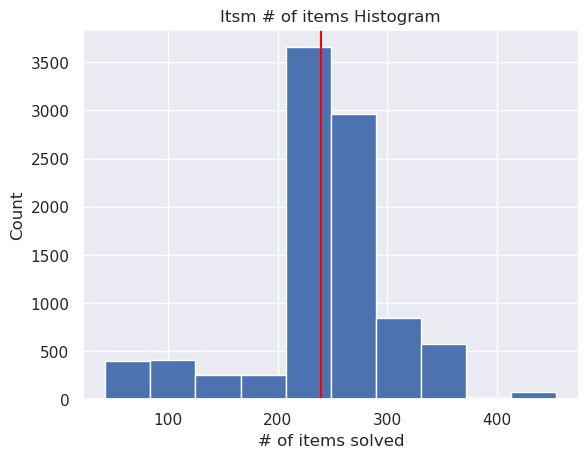

In [18]:
# 문항별 개수 도수분포표
fig, ax = plt.subplots()

item_df['count'].hist(bins=10, ax=ax)

ax.set_title('Itsm # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(item_df['count'].mean(), color='red')
ax.grid(b=True)

/tmp/ipykernel_19447/369142873.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


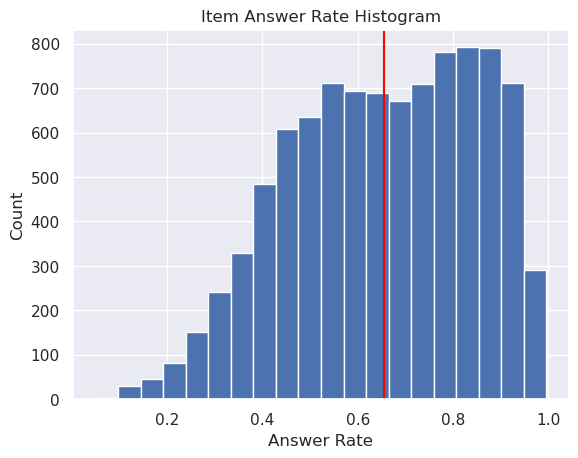

In [19]:
# 아이템 정답률 도수분포표
fig, ax = plt.subplots()

item_df['mean'].hist(bins=20)

ax.set_title('Item Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(item_df['mean'].mean(), color='red')
ax.grid(b=True)

### 1) 많이 푼 문제일 수록 정답률이 높은가?

Text(0.5, 1.0, '# of Questions - Answer Rate')

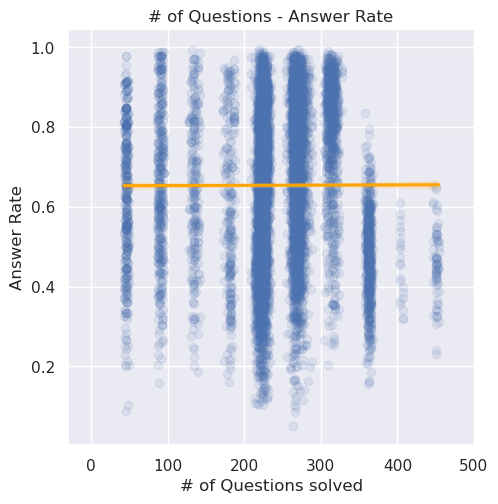

In [34]:
# 단순히 문제 수로 count
g = sns.lmplot(
	data = item_df,
	x='count',
	y='mean',
	scatter_kws={'alpha':0.1},
	line_kws={"color": "orange"}
)

g.set_xlabels('# of Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 500))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

### 1-1) 문제 별 푼 학생 수 = 시험지 별 푼 학생 수?
`item_count`, `test_count`

In [36]:
# 문제별 푼 학생 수
item_user_df = df.groupby('assessmentItemID')['userID'].agg({'nunique', 'mean'})
item_dict = item_user_df.to_dict()
df['item_count'] = df['assessmentItemID'].map(item_dict['nunique'])

# 시험지별 푼 학생 수
test_user_df = df.groupby('testId')['userID'].agg({'nunique', 'mean'})
test_dict = test_user_df.to_dict()
df['test_count'] = df['testId'].map(test_dict['nunique'])


In [22]:
print(len(df))
print(len(df[df['item_count'] == df['test_count']]))

2266586
2266586


Text(0.5, 1.0, '# of Questions - Answer Rate')

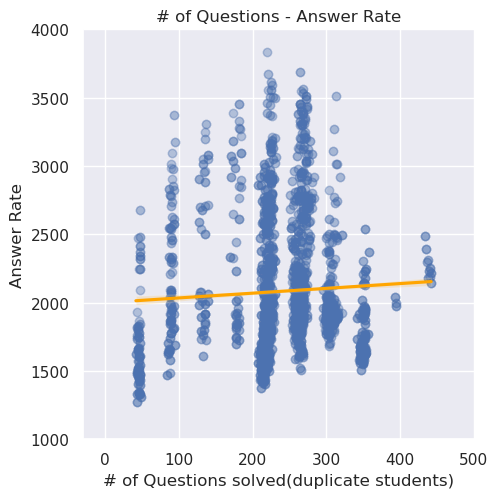

In [41]:
# 해당 문제를 푼 학생 unique 개수
g = sns.lmplot(
	data = item_user_df,
	x='nunique',
	y='mean',
	scatter_kws={'alpha':0.1},
	line_kws={"color": "orange"}
)

g.set_xlabels('# of Questions solved(duplicate students)')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 500))
g.set(ylim=(1000, 4000))

ax = plt.gca()
ax.set_title('# of Questions - Answer Rate')

### 2) 마지막 세자리(문제 번호) 별 평균
`item_num`
* 뒤로 갈수록 평균 낮아짐 > 뒤로 갈수록 어려운 문제

In [23]:
df['item_num'] = df['assessmentItemID'].str[7:]

item_num_df = df.groupby('item_num')['answerCode'].agg({'count', 'mean'})
item_num_df

,count,mean
item_num,,
001,371755,0.749916
002,370972,0.720062
003,371640,0.687773
004,369705,0.663364
005,360607,0.599134
006,197772,0.555685
007,127121,0.515399
008,67150,0.457156
009,18417,0.481729


<BarContainer object of 13 artists>

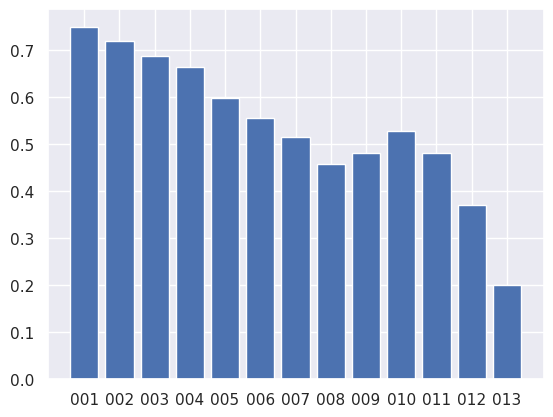

In [24]:
plt.bar(item_num_df.index, item_num_df['mean'])

### 1-3) 같은 문제 또 푸는 경우
`same_item_cnt`

In [25]:
df['same_item_cnt'] = df.groupby(['userID', 'assessmentItemID']).cumcount() + 1
df['same_item_cnt'].value_counts()

1    2220633
2      45119
3        834
Name: same_item_cnt, dtype: int64

In [26]:
df.groupby('same_item_cnt')['answerCode'].agg({'mean'})


,mean
same_item_cnt,
1,0.654647
2,0.645138
3,0.438849


### 1-4) 누적 문제 개수 와 정답률
`cum_item_cnt`

In [27]:
df['cum_item_cnt'] = df.groupby(['userID']).cumcount()

cum_item_df = df.groupby('cum_item_cnt')['answerCode'].agg({'mean'}).reset_index()

Text(0.5, 1.0, '# of cumulative Questions - Answer Rate')

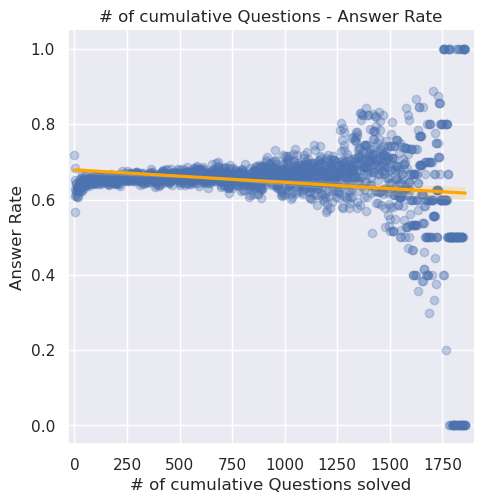

In [28]:
g = sns.lmplot(
    data=cum_item_df,
    x='cum_item_cnt',
    y='mean',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of cumulative Questions solved')
g.set_ylabels('Answer Rate')
g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of cumulative Questions - Answer Rate')

<br><br>
## 1-3. testId

### 1) 문제지별 평균/개수

In [30]:
test_df = df.groupby('testId')['answerCode'].agg({'mean', 'count'})
test_df = test_df.sort_values(by='count', ascending=False)

/tmp/ipykernel_19447/774821586.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


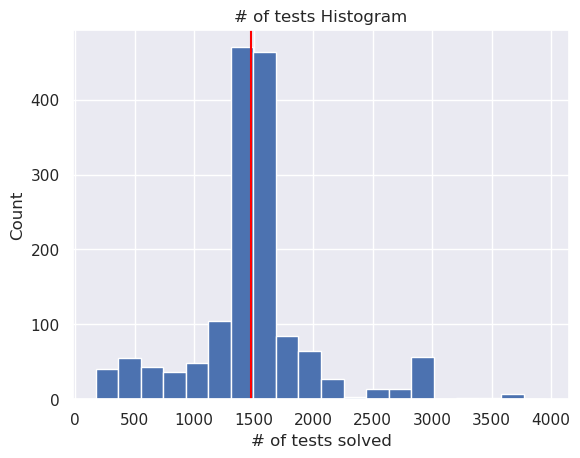

In [44]:
# 시험지별 개수 도수분포표
fig, ax = plt.subplots()

test_df['count'].hist(bins=20, ax=ax)

ax.set_title('# of tests Histogram')
ax.set_xlabel('# of tests solved')
ax.set_ylabel('Count')
ax.axvline(test_df['count'].mean(), color='red')
ax.grid(b=True)

### 2) 문제지별 몇개의 문제가 포함?

In [133]:
test_item = df.groupby('testId').agg({'assessmentItemID': 'nunique'})
test_item

,assessmentItemID
testId,
A010000001,5
A010000002,5
A010000003,5
A010000004,5
A010000005,5
...,...
A090000070,8
A090000071,8
A090000072,6


<BarContainer object of 12 artists>

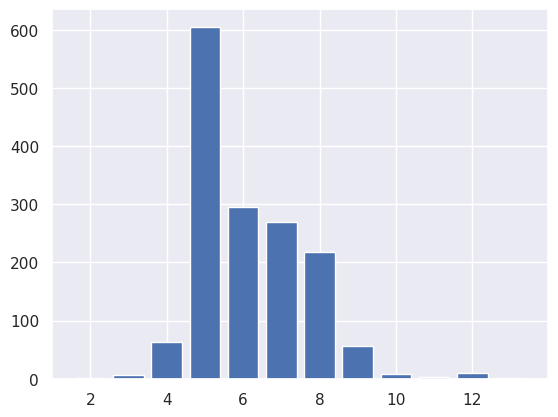

In [56]:
# 문제지 내 문제 개수 분포표
test_item_cnt = test_item.groupby('assessmentItemID').agg({'assessmentItemID': 'count'})
plt.bar(test_item_cnt.index, test_item_cnt['assessmentItemID'])

### 3) 문제지별 tag 분류는 다른가?

In [57]:
test_tag = df.groupby('testId').agg({'KnowledgeTag': 'nunique'})

<BarContainer object of 8 artists>

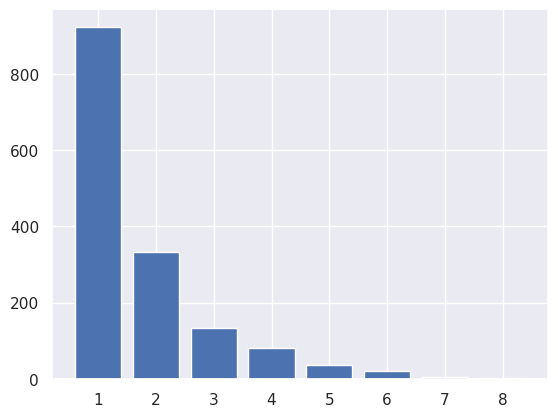

In [58]:
# 문제지 내 태그 개수 분포표
test_tag_cnt = test_tag.groupby('KnowledgeTag').agg({'KnowledgeTag': 'count'})
plt.bar(test_tag_cnt.index, test_tag_cnt['KnowledgeTag'])

### 4) 문제지 별 푼 학생수와 정답률
많이 푼 문제지일 수록 쉬운 문제지?

In [61]:
test_df_dup = df.groupby('testId').agg({'userID': 'nunique', 'answerCode': 'mean'})

Text(0.5, 1.0, '# of cumulative Questions - Answer Rate')

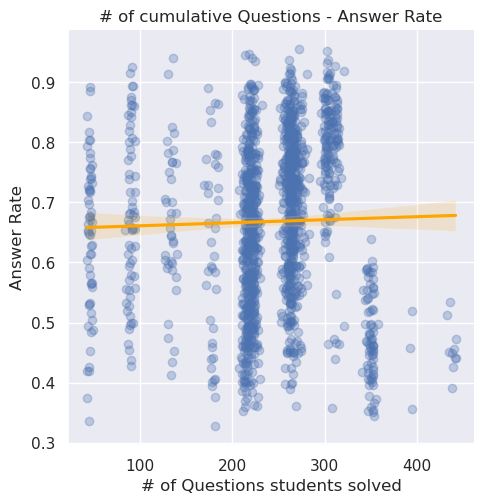

In [64]:
g = sns.lmplot(
    data=test_df_dup,
    x='userID',
    y='answerCode',
    scatter_kws={'alpha':0.3},
    line_kws={"color": "orange"}
)
g.set_xlabels('# of Questions students solved')
g.set_ylabels('Answer Rate')

ax = plt.gca()
ax.set_title('# of cumulative Questions - Answer Rate')

<br><br>
## 1-4. Timestamp

### 1) 문제지 내 푼 순서 당 평균
* 먼저 푼 문제 일 수록 쉬운 문제?
* 문제지 번호와 얼마나 다른가?

In [68]:
df['item_seq_test'] = df.groupby(['userID', 'testId']).cumcount() + 1

In [75]:
print('원래 데이터:', len(df))
print('문제번호랑 푼 순서 다른 데이터:', len(df[df['item_num'].astype(int) != df['item_seq_test']]))

원래 데이터: 2266586
문제번호랑 푼 순서 다른 데이터: 183347


In [76]:
item_seq_df = df.groupby('item_seq_test')['answerCode'].agg({'count', 'mean'})
item_seq_df

,count,mean
item_seq_test,,
1,365164,0.750994
2,365164,0.721164
3,364905,0.690043
4,363325,0.662836
5,351048,0.598949
6,197044,0.557672
7,127846,0.519664
8,71221,0.473021
9,24330,0.530538


<BarContainer object of 27 artists>

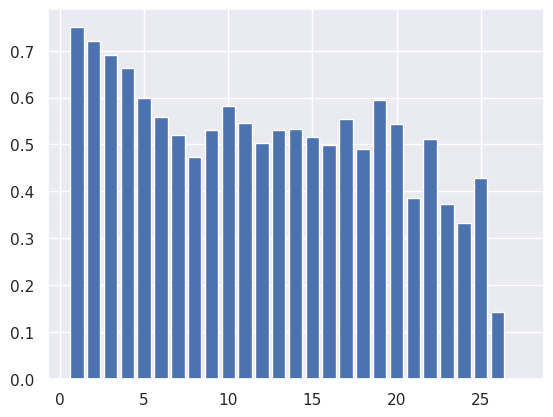

In [77]:
plt.bar(item_seq_df.index, item_seq_df['mean'])

#### ⁉️ 문제지 내 문제 최대 개수는 13개였는데, 문제지 seq에 14이상이 존재???
* 다음날 똑같은 문제지 풀면 연속해서 푼다고 인식 >> 일자 데이터 넣어주기
* 일자 데이터 계산해서 다시 계산해야 하는 것
    * `solved_time_test_date`: 다음날 똑같은 문제지를 풀 경우 첫번째 문제 푼 시간이 비정상적으로 길게 나옴
    * `item_seq_test_date`: 14이내로 나와야함

In [80]:
df[df['item_seq_test'] > 25]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solved_time,solved_time_test,item_count,test_count,item_num,same_item_cnt,cum_item_cnt,item_seq_test
494269,693,A070021007,A070000021,0,2020-05-20 06:09:18,5762,7.0,7.0,211,211,007,3,305,26
494270,693,A070021008,A070000021,0,2020-05-20 06:09:30,5783,12.0,12.0,211,211,008,3,306,27
494514,693,A070031008,A070000031,0,2020-08-19 05:47:55,5788,3.0,3.0,211,211,008,3,550,26
494515,693,A070031009,A070000031,0,2020-08-19 05:47:58,5788,3.0,3.0,211,211,009,3,551,27
663328,950,A040184013,A040000184,0,2020-10-05 10:05:37,2125,86.0,86.0,264,264,013,2,1260,26
1719599,3099,A040184013,A040000184,1,2020-08-08 02:03:45,2125,79.0,79.0,264,264,013,2,337,26
2080038,4640,A040184013,A040000184,0,2020-09-05 04:30:13,2125,129.0,129.0,264,264,013,2,95,26
2161405,5303,A040184013,A040000184,0,2020-10-25 00:45:05,2125,74.0,74.0,264,264,013,2,82,26
2178835,5508,A040184013,A040000184,0,2020-10-23 11:41:02,2125,29.0,29.0,264,264,013,2,192,26


In [83]:
df[(df['userID']==693) & (df['testId']=='A070000021')][['assessmentItemID', 'Timestamp', 'solved_time_test', 'same_item_cnt', 'item_seq_test', 'answerCode']]

,assessmentItemID,Timestamp,solved_time_test,same_item_cnt,item_seq_test,answerCode
494073,A070021001,2020-03-31 05:46:28,0.0,1,1,0
494074,A070021004,2020-03-31 05:47:12,44.0,1,2,0
494075,A070021005,2020-03-31 05:49:06,114.0,1,3,1
494076,A070021006,2020-03-31 05:49:11,5.0,1,4,0
494077,A070021009,2020-03-31 05:49:14,3.0,1,5,0
494078,A070021008,2020-03-31 05:49:16,2.0,1,6,0
494079,A070021007,2020-03-31 05:49:24,8.0,1,7,0
494080,A070021003,2020-03-31 05:49:56,32.0,1,8,1
494081,A070021002,2020-03-31 05:49:57,1.0,1,9,0
494091,A070021001,2020-04-02 16:51:21,212484.0,2,10,0


solved_time_test_date 구하기

In [87]:
df['date'] = df['Timestamp'].transform(lambda x: pd.to_datetime(x, unit='s').dt.date)

In [88]:
# 유저, test, date로 구분했을 때 문제 푸는데 걸린 시간
diff_test_date = df.loc[:, ['userID', 'testId', 'Timestamp', 'date']].groupby(['userID', 'testId', 'date']).diff().fillna(pd.Timedelta(seconds=0))
diff_test_date = diff_test_date.fillna(pd.Timedelta(seconds=0))
diff_test_date = diff_test_date['Timestamp'].apply(lambda x: x.total_seconds())

df['solved_time_test_date'] = diff_test_date
df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solved_time,solved_time_test,item_count,test_count,item_num,same_item_cnt,cum_item_cnt,item_seq_test,date,solved_time_test_date
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.0,0.0,218,218,001,1,0,1,2020-03-24,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3.0,3.0,218,218,002,1,1,2,2020-03-24,3.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8.0,8.0,218,218,003,1,2,3,2020-03-24,8.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7.0,7.0,218,218,004,1,3,4,2020-03-24,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7.0,7.0,218,218,005,1,4,5,2020-03-24,7.0


In [90]:
# 문제 번호 001로 끝나는게 값 다름 > 첫번쨰 문제 처리 방식이 다르기 때문
print('유저로만 묶었을 때 푸는데 걸린 시간 평균', df['solved_time'].mean())
print('유저, 문제지로 묶었을 때 푸는데 걸린 시간 평균', df['solved_time_test'].mean())
print('유저, 문제지, 날짜로 묶었을 때 푸는데 걸린 시간 평균', df['solved_time_test_date'].mean())
df[df['solved_time_test'] != df['solved_time_test_date']][['solved_time', 'solved_time_test', 'solved_time_test_date']].head()

유저로만 묶었을 때 푸는데 걸린 시간 평균 52685.91680792169
유저, 문제지로 묶었을 때 푸는데 걸린 시간 평균 14486.002520089685
유저, 문제지, 날짜로 묶었을 때 푸는데 걸린 시간 평균 80.34490153914301


,solved_time,solved_time_test,solved_time_test_date
1397,298696.0,4877683.0,0.0
1403,3536.0,4714763.0,0.0
1409,56852.0,4332967.0,0.0
1419,14638.0,4249697.0,0.0
1439,46006.0,3850556.0,0.0


item_seq_test_date 구하기

In [91]:
df['item_seq_test_date'] = df.groupby(['userID', 'testId', 'date']).cumcount() + 1

In [92]:
print('원래 데이터:', len(df))
print('문제번호랑 푼 순서 다른 데이터:', len(df[df['item_num'].astype(int) != df['item_seq_test_date']]))

원래 데이터: 2266586
문제번호랑 푼 순서 다른 데이터: 146767


In [93]:
item_seq_date_df = df.groupby('item_seq_test_date')['answerCode'].agg({'count', 'mean'})
item_seq_date_df

,count,mean
item_seq_test_date,,
1,374921,0.750262
2,374036,0.720391
3,372942,0.689381
4,370458,0.662299
5,356931,0.598371
6,197110,0.553249
7,124946,0.510845
8,66040,0.449561
9,17686,0.477383


#### ⁉️ 조정 후에도, 문제지 seq에 14이상이 존재???
* 몇시간 후에 풀어보는 독한 놈이 있네..
* 푼 시간이 7462초 이렇게 비정상적으로 기록
    * 푼 시간이 일정 시간 넘어가면 다음에 푼다고 해야하는지??
    * 원래 방법은 날짜만 넘어가면 다음에 푸는걸로 취급해버리는 문제도 있음
* 대충 1~14까지만 봤을 때 뒤에 풀수록 정답률 하락

In [174]:
df[(df['solved_time_test_date']<7200) & (df['solved_time_test_date']>6000)]
# df[df['item_num'] != '001']['solved_time_test_date'].sort_values().tail(20000)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solved_time,solved_time_test,item_count,test_count,item_num,same_item_cnt,cum_item_cnt,item_seq_test,date,solved_time_test_date,item_seq_test_date,hour,same_tag_cnt
4172,7,A020085003,A020000085,1,2020-07-02 06:45:13,7822,6990.0,6990.0,259,259,003,1,464,3,2020-07-02,6990.0,3,6,3
12740,20,A050004006,A050000004,0,2020-03-05 04:57:29,2616,6297.0,6297.0,216,216,006,1,18,6,2020-03-05,6297.0,6,4,6
14011,21,A050104004,A050000104,1,2020-06-05 06:55:03,5269,6120.0,6120.0,221,221,004,1,571,4,2020-06-05,6120.0,4,6,6
14207,21,A050164005,A050000164,1,2020-07-03 06:12:27,457,6948.0,6948.0,227,227,005,1,767,5,2020-07-03,6948.0,5,6,4
18956,27,A050019005,A050000019,1,2020-03-19 02:19:42,2622,6710.0,6710.0,212,212,005,1,95,5,2020-03-19,6710.0,5,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249413,6730,A030148002,A030000148,1,2020-10-15 10:23:18,7818,6002.0,6002.0,273,273,002,1,29,2,2020-10-15,6002.0,2,10,2
2250111,6750,A060152003,A060000152,1,2020-10-26 11:23:16,1458,6724.0,6724.0,225,225,003,1,7,3,2020-10-26,6724.0,3,11,3
2256131,6925,A060175006,A060000175,0,2020-10-23 12:45:27,1576,6037.0,6037.0,217,217,006,1,17,6,2020-10-23,6037.0,6,12,4
2260851,7124,A020184005,A020000184,0,2020-09-08 05:15:44,8093,7188.0,7188.0,279,279,005,1,17,5,2020-09-08,7188.0,5,5,2


In [175]:
# df[(df['userID']==4583) & (df['testId']=='A060000143')][['assessmentItemID', 'Timestamp', 'solved_time_test_date', 'same_item_cnt', 'item_seq_test_date', 'answerCode']]
df[(df['userID']==21) & (df['testId']=='A050000104')][['assessmentItemID', 'Timestamp', 'solved_time_test_date', 'same_item_cnt', 'item_seq_test_date', 'answerCode']]

,assessmentItemID,Timestamp,solved_time_test_date,same_item_cnt,item_seq_test_date,answerCode
14008,A050104001,2020-06-05 04:56:54,0.0,1,1,1
14009,A050104002,2020-06-05 05:12:54,960.0,1,2,1
14010,A050104003,2020-06-05 05:13:03,9.0,1,3,1
14011,A050104004,2020-06-05 06:55:03,6120.0,1,4,1
14012,A050104005,2020-06-05 06:55:17,14.0,1,5,1
14013,A050104006,2020-06-05 07:02:04,407.0,1,6,1
14014,A050104007,2020-06-05 07:02:13,9.0,1,7,0


<BarContainer object of 22 artists>

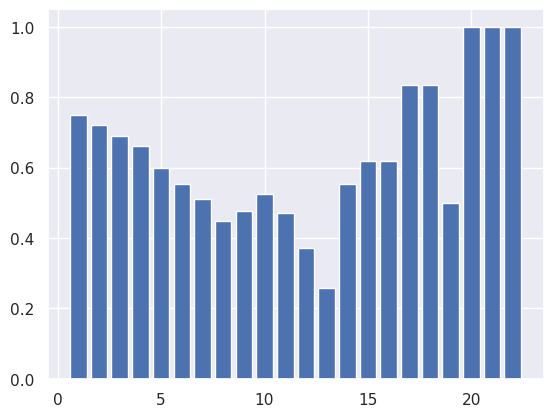

In [94]:
plt.bar(item_seq_date_df.index, item_seq_date_df['mean'])

### 2) 문제 푼 시간별 평균
오래 걸릴 수록 어려운 문제?

In [105]:
elapsed_hist = df.groupby('solved_time_test_date')['answerCode'].agg({'count', 'mean'})
elapsed_hist = elapsed_hist[elapsed_hist['count']>100]
elapsed_hist

,count,mean
solved_time_test_date,,
0.0,382291,0.744501
1.0,53770,0.246439
2.0,109952,0.227172
3.0,75745,0.229018
4.0,49972,0.247999
...,...,...
519.0,109,0.642202
522.0,103,0.592233
531.0,103,0.601942


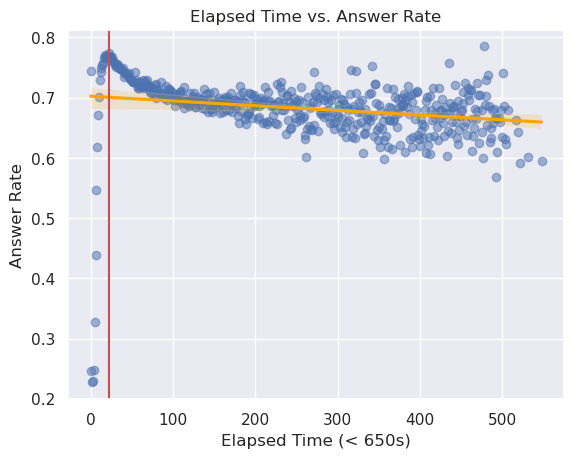

In [109]:
fig, ax = plt.subplots()
g = sns.regplot(x=elapsed_hist.index[:-1], y=elapsed_hist['mean'].values[:-1],
            scatter_kws={'alpha':0.5}, line_kws={"color": "orange"}, ax=ax)
ax.set_title('Elapsed Time vs. Answer Rate')
ax.set_xlabel('Elapsed Time (< 650s)')
ax.set_ylabel('Answer Rate')
ax.axvline(22, color='r')

### 3) 문제지 푼 시간별 평균

### 4) 시간대별 평균

In [110]:
df['hour'] = df['Timestamp'].transform(lambda x: pd.to_datetime(x, unit='s').dt.hour)

In [112]:
hour_df = df.groupby('hour')['answerCode'].agg({'count', 'mean'})

<BarContainer object of 24 artists>

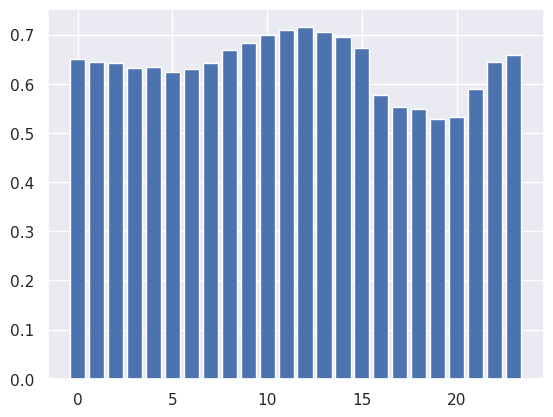

In [113]:
plt.bar(hour_df.index, hour_df['mean'])

### 시간 전처리

In [203]:
# 유저, test, same_로 구분했을 때 문제 푸는데 걸린 시간
df['solved_time_shift'] = df.loc[:, ['userID', 'testId', 'Timestamp', 'same_item_cnt']].groupby(['userID', 'testId', 'same_item_cnt']).diff().shift(-1)['Timestamp'].apply(lambda x: x.total_seconds())
df['solved_time_not_shift'] = df.loc[:, ['userID', 'testId', 'Timestamp', 'same_item_cnt']].groupby(['userID', 'testId', 'same_item_cnt']).diff()['Timestamp'].apply(lambda x: x.total_seconds())


# diff_test_date = df.loc[:, ['userID', 'testId', 'Timestamp', 'same_item_cnt']].groupby(['userID', 'testId', 'date']).diff().fillna(pd.Timedelta(seconds=0))
# diff_test_date = diff_test_date.fillna(pd.Timedelta(seconds=0))
# diff_test_date = diff_test_date['Timestamp'].apply(lambda x: x.total_seconds())

# df['solved_time_test_date'] = diff_test_date
# df.head()

In [205]:
df[(df['solved_time_shift']>3600) & (df['same_item_cnt']>1)][['userID', 'testId', 'solved_time_test_date', 'solved_time_shift', 'solved_time_not_shift']]

,userID,testId,solved_time_test_date,solved_time_shift,solved_time_not_shift
25426,34,A080000029,81.0,4402.0,81.0
90730,117,A070000037,17.0,74226.0,17.0
137412,176,A020000150,0.0,4346.0,NaN
143606,186,A050000018,46.0,4677.0,46.0
185019,248,A080000115,1.0,74790.0,1.0
...,...,...,...,...,...
2055699,4478,A020000057,55.0,10293.0,55.0
2058339,4491,A050000173,30.0,16555.0,30.0
2080039,4640,A040000195,0.0,6418.0,NaN
2142441,5125,A010000138,411.0,4908.0,411.0


In [206]:
df[(df['userID']==117) & (df['testId']=='A070000037')][['assessmentItemID', 'Timestamp', 'solved_time_shift','solved_time_not_shift', 'same_item_cnt', 'item_seq_test_date', 'answerCode']]

,assessmentItemID,Timestamp,solved_time_shift,solved_time_not_shift,same_item_cnt,item_seq_test_date,answerCode
90658,A070037001,2020-03-05 04:00:05,113.0,NaN,1,1,1
90659,A070037002,2020-03-05 04:01:58,86.0,113.0,1,2,1
90660,A070037005,2020-03-05 04:03:24,31.0,86.0,1,3,1
90661,A070037003,2020-03-05 04:03:55,207.0,31.0,1,4,1
90662,A070037004,2020-03-05 04:07:22,24.0,207.0,1,5,1
90663,A070037006,2020-03-05 04:07:46,NaN,24.0,1,6,1
90725,A070037001,2020-03-13 02:05:59,34.0,NaN,2,1,1
90726,A070037002,2020-03-13 02:06:33,28.0,34.0,2,2,1
90727,A070037003,2020-03-13 02:07:01,464.0,28.0,2,3,0
90728,A070037004,2020-03-13 02:14:45,36.0,464.0,2,4,1


In [207]:
df[(df['userID']==117) &]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,solved_time,solved_time_test,item_count,test_count,...,same_item_cnt,cum_item_cnt,item_seq_test,date,solved_time_test_date,item_seq_test_date,hour,same_tag_cnt,solved_time_shift,solved_time_not_shift
90506,117,A070013001,A070000013,1,2020-02-07 04:43:13,3821,0.0,0.0,217,217,...,1,0,1,2020-02-07,0.0,1,4,1,40.0,NaN
90507,117,A070013002,A070000013,0,2020-02-07 04:43:53,3821,40.0,40.0,217,217,...,1,1,2,2020-02-07,40.0,2,4,2,59.0,40.0
90508,117,A070013003,A070000013,1,2020-02-07 04:44:52,3821,59.0,59.0,217,217,...,1,2,3,2020-02-07,59.0,3,4,3,109.0,59.0
90509,117,A070013004,A070000013,0,2020-02-07 04:46:41,3821,109.0,109.0,217,217,...,1,3,4,2020-02-07,109.0,4,4,4,15.0,109.0
90510,117,A070013005,A070000013,1,2020-02-07 04:46:56,3821,15.0,15.0,217,217,...,1,4,5,2020-02-07,15.0,5,4,5,87.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91999,117,A070095003,A070000095,0,2020-12-29 04:06:45,8893,3.0,3.0,212,212,...,2,1493,12,2020-12-29,3.0,4,4,9,3.0,3.0
92000,117,A070095005,A070000095,0,2020-12-29 04:06:48,8893,3.0,3.0,212,212,...,2,1494,13,2020-12-29,3.0,5,4,10,2.0,3.0
92001,117,A070095006,A070000095,0,2020-12-29 04:06:50,8893,2.0,2.0,212,212,...,2,1495,14,2020-12-29,2.0,6,4,11,2.0,2.0
92002,117,A070095007,A070000095,0,2020-12-29 04:06:52,8896,2.0,2.0,212,212,...,2,1496,15,2020-12-29,2.0,7,4,10,3.0,2.0


<br><br>
## 1-5. KnowledgeTag

### 1) 태그당 평균, 개수

In [114]:
tag_df = df.groupby('KnowledgeTag')['answerCode'].agg({'count', 'mean'})
tag_df

,count,mean
KnowledgeTag,,
23,1800,0.584444
24,358,0.614525
25,92,0.858696
26,2432,0.614309
30,539,0.536178
...,...,...
11253,4282,0.739374
11265,454,0.676211
11269,2417,0.557716


/tmp/ipykernel_19447/1114319523.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


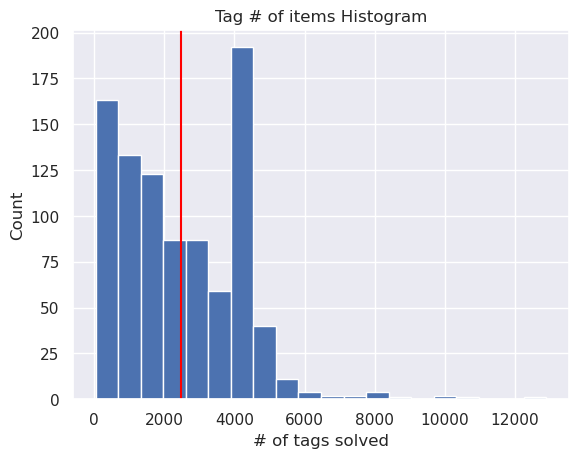

In [115]:
# 사용자 문항 개수 도수분포표
fig, ax = plt.subplots()

tag_df['count'].hist(bins=20, ax=ax)

ax.set_title('Tag # of items Histogram')
ax.set_xlabel('# of tags solved')
ax.set_ylabel('Count')
ax.axvline(tag_df['count'].mean(), color='red')
ax.grid(b=True)

### 2) 태그 개수별 평균 정답률

Text(0.5, 1.0, '# of Tags - Answer Rate')

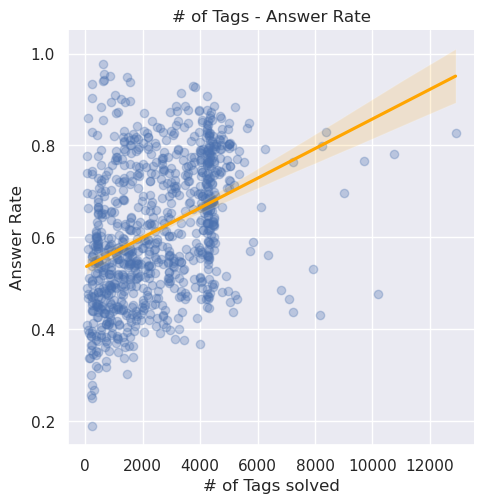

In [116]:
g = sns.lmplot(
	data = tag_df,
	x='count',
	y='mean',
	scatter_kws={'alpha':0.3},
	line_kws={"color": "orange"}
)

g.set_xlabels('# of Tags solved')
g.set_ylabels('Answer Rate')
# g.set(xlim=(-30, 1900))

ax = plt.gca()
ax.set_title('# of Tags - Answer Rate')

### 3) 같은 태그 또 풀면?

In [119]:
df['same_tag_cnt'] = df.groupby(['userID', 'KnowledgeTag']).cumcount()+1

In [130]:
same_tag_df = df.groupby('same_tag_cnt')['answerCode'].agg({'count', 'mean'})
same_tag_df = same_tag_df[same_tag_df['count'] > 10]

In [134]:
same_tag_df

,count,mean
same_tag_cnt,,
1,440802,0.687678
2,378819,0.668958
3,328948,0.651066
4,282714,0.643764
5,241599,0.600541
6,142333,0.619660
7,102843,0.636922
8,72406,0.683728
9,62575,0.677123


<BarContainer object of 53 artists>

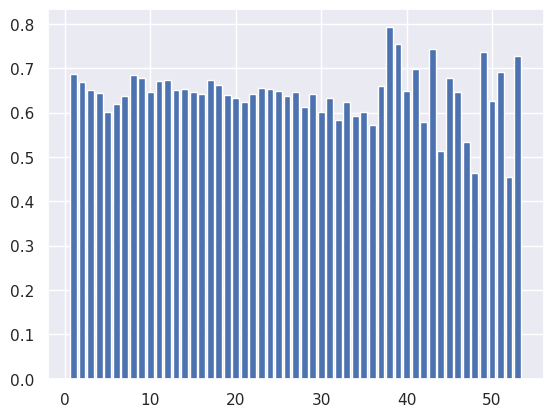

In [131]:
plt.bar(same_tag_df.index, same_tag_df['mean'])